# MSAAI_520 Assignment 7 - Agentic AI for Financial Analysis

**Team Members:** Pros Loung, Dennis Arapurayil, Divya Kamath

**Institution:** University of San Diego  
**Course:** Natural Language Processing and GenAI (AAI-520)  
**Professor:** Kahila Mokhtari Jadid  
**GitHub:** https://github.com/denjcodes/AAI_520_Final_Project.git

---

### Overview

This notebook implements a **comprehensive autonomous Investment Research Agent System** that:

**Plans** research steps for stock analysis (Planner Agent)  
**Routes** tasks intelligently to specialized agents (Router Agent)  
**Fetches** real-time financial data (Yahoo Finance, News API, SEC)  
**Analyzes** using multiple workflow patterns (Prompt Chaining, Routing, Evaluator-Optimizer)  
**Self-reflects** on output quality with iterative improvement  
**Learns** from previous analyses using persistent memory  
**Coordinates** multiple specialized agents via Master Coordinator  

---

### System Architecture

```
                 Investment Research Workflow                   
─────────────────────────────────────────────────────────────── 
                                                                
                        User Request                            
                              ↓                                 
               InvestmentResearchCoordinator                    
                              ↓                                 
                 Phase 1: Planning & Data Collection            
                        • LeadAnalyst.plan()                    
                        • RoutingWorkflow → MarketAnalyst /     
                                            NewsAnalyst /       
                                            FundamentalAnalyst  
                        • PromptChainWorkflow (News Processing) 
                              ↓                                 
                 Phase 2: Initial Analysis Generation           
                              ↓                                 
                 Phase 3: EvaluatorOptimizer                    
                        (Iterative Refinement)                  
                              ↓                                 
                 Phase 4: Self-Reflection (LeadAnalyst)         
                              ↓                                 
                 Phase 5: Learning & MemoryAgent                
                        (Persistent Knowledge)                  
                              ↓                                 
                 Executive Summary → JSON Output                
```

#### Key Agentic Patterns Implemented:

1. **Prompt Chaining**: News Ingestion → Preprocessing → Classification → Extraction → Summarization
2. **Intelligent Routing**: Dynamic task allocation based on content analysis
3. **Evaluator-Optimizer**: Iterative quality improvement with feedback loops
4. **Memory & Learning**: Persistent context across sessions for continuous improvement
5. **Self-Reflection**: Agents critique their own outputs and trigger re-analysis

---

In [ ]:
# All imports
import json
import logging
import os
import pickle
import re
import time
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from datetime import datetime, timedelta
from enum import Enum
from typing import Any, Dict, List, Optional, Tuple

import certifi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import yfinance as yf
from dotenv import load_dotenv
from openai import OpenAI

# Configure styling
sns.set_style('whitegrid')

# SSL Certificate fix for Yahoo Finance
os.environ['SSL_CERT_FILE'] = certifi.where()
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()

# Load environment variables
load_dotenv()

# Configuration - Load from .env file
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
NEWSAPI_KEY = os.getenv('NEWSAPI_KEY')
SEC_API_KEY = os.getenv('SEC_API_KEY')

# Setup logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')

# Initialize OpenAI client
if OPENAI_API_KEY:
    client = OpenAI(api_key=OPENAI_API_KEY)
    print('OpenAI client initialized')
else:
    print('Warning: OpenAI API key not found in .env file')



# Verify setup
print(f'yfinance version: {yf.__version__}')
print('All imports and configuration loaded successfully')

OpenAI client initialized
yfinance version: 0.2.66
All imports and configuration loaded successfully


## 1. Data Adapters

In [2]:
# Data adapters
from adapters import YahooFinanceAdapter, NewsAdapter, SECAdapter

YahooFinanceAdapter(health_check=True)
NewsAdapter(health_check=True)
SECAdapter(health_check=True)


YahooFinanceAdapter Health Check
Testing with ticker: AAPL
Test initiated at: 2025-10-17 20:31:23.120519

[1/4] Creating ticker object... Success
[2/4] Fetching ticker info... Success (Apple Inc.)
[3/4] Fetching price history (5 days)... Success (5 days, latest $252.29 on 2025-10-17)
[4/4] Verifying data quality... Success

Health Check Passed


NewsAdapter Health Check

[1/3] Checking API key... Success

NewsAdapter Health Check
[2/3] Testing API connection... Success
[3/3] Verifying response data... Success

Health Check Passed


SECAdapter Health Check

[1/3] Checking API key... Success
[2/3] Testing API connection... Success
[3/3] Verifying response data... Success

Health Check Passed



## 2. Agent Infrastructure

In [3]:
class MemoryAgent:
    """JSON-backed persistent memory for agents"""
    
    def __init__(self, path: str = './agent_memory.json'):
        self.path = path
        self.state: Dict[str, Any] = {}
        self._load()

    def _load(self):
        if os.path.exists(self.path):
            try:
                with open(self.path, 'r', encoding='utf-8') as f:
                    self.state = json.load(f)
            except (json.JSONDecodeError, OSError):
                self.state = {}
        else:
            self.state = {}

    def save(self):
        try:
            with open(self.path, 'w', encoding='utf-8') as f:
                json.dump(self.state, f, indent=2)
        except OSError as e:
            logging.error(f'Error saving memory: {e}')

    def append(self, key: str, value: Any):
        arr = self.state.get(key, [])
        if not isinstance(arr, list):
            arr = [arr]
        arr.append(value)
        self.state[key] = arr
        self.save()

    def get(self, key: str, default: Any = None) -> Any:
        return self.state.get(key, default)

    def set(self, key: str, value: Any):
        self.state[key] = value
        self.save()

print('MemoryAgent loaded.')

MemoryAgent loaded.


In [4]:
class AgentState(Enum):
    """Agent states for workflow management"""
    IDLE = 'idle'
    PLANNING = 'planning'
    EXECUTING = 'executing'
    REFLECTING = 'reflecting'
    LEARNING = 'learning'

print('AgentState enum loaded.')

AgentState enum loaded.


In [5]:
class BaseFinancialAgent:
    """Enhanced base agent with planning, reflection, and learning"""
    
    def __init__(self, name: str, role: str, model: str = 'gpt-4o-mini'):
        self.name, self.role, self.model, self.state = name, role, model, AgentState.IDLE
        self.short_term_memory, self.long_term_memory, self.reflection_log = [], self._load_memory(), []
        self.current_plan, self.plan_progress = None, {}
        self.yahoo_adapter, self.news_adapter, self.sec_adapter = YahooFinanceAdapter(), NewsAdapter(), SECAdapter()
        
    def _load_memory(self) -> Dict:
        mem_file = f'{self.name}_memory.pkl'
        if os.path.exists(mem_file):
            try:
                with open(mem_file, 'rb') as f: return pickle.load(f)
            except: pass
        return {'analyses': [], 'patterns': {}, 'improvements': []}
    
    def _save_memory(self):
        with open(f'{self.name}_memory.pkl', 'wb') as f: pickle.dump(self.long_term_memory, f)
    
    def plan(self, task: str) -> List[str]:
        self.state = AgentState.PLANNING
        prompt = f"As a {self.role}, create a step-by-step plan for: {task}\nConsider: data needed, analysis methods, quality checks.\nPrevious analyses: {len(self.long_term_memory['analyses'])}\nReturn numbered list."
        plan_text = self.call_llm(prompt)
        steps = [s.strip() for s in plan_text.split('\n') if s.strip() and any(c.isdigit() for c in s[:3])]
        self.current_plan, self.plan_progress = steps, {s: False for s in steps}
        print(f'{self.name} created plan with {len(steps)} steps')
        return steps
    
    def execute_plan(self) -> Dict:
        if not self.current_plan: return {'error': 'No plan to execute'}
        self.state, results = AgentState.EXECUTING, {}
        for step in self.current_plan:
            if not self.plan_progress[step]:
                print(f'  Executing: {step[:50]}...')
                results[step] = self.execute_step(step)
                self.plan_progress[step] = True
        return results
    
    def execute_step(self, step: str) -> Any:
        sl, sym = step.lower(), self.extract_symbol_from_context()
        
        if ('stock data' in sl or 'price' in sl) and sym:
            info, prices = self.yahoo_adapter.fetch_info(sym), self.yahoo_adapter.fetch_prices(sym, period='1mo')
            return {
                'symbol': sym, 'company_name': info.get('longName', 'N/A'), 'sector': info.get('sector', 'N/A'),
                'current_price': info.get('currentPrice', prices['Close'].iloc[-1] if not prices.empty else None),
                'market_cap': info.get('marketCap', 'N/A'), 'pe_ratio': info.get('trailingPE', 'N/A'),
                'dividend_yield': info.get('dividendYield', 'N/A'), '52_week_high': info.get('fiftyTwoWeekHigh', 'N/A'),
                '52_week_low': info.get('fiftyTwoWeekLow', 'N/A'), 'avg_volume': info.get('averageVolume', 'N/A'),
                'recommendation': info.get('recommendationKey', 'N/A')
            }
        elif ('financial statement' in sl or 'earnings' in sl) and sym:
            fin, bs, cf = self.yahoo_adapter.fetch_financials(sym), self.yahoo_adapter.fetch_balance_sheet(sym), self.yahoo_adapter.fetch_cashflow(sym)
            return {'income_statement': fin.to_dict() if not fin.empty else {}, 'balance_sheet': bs.to_dict() if not bs.empty else {}, 'cash_flow': cf.to_dict() if not cf.empty else {}}
        elif 'news' in sl:
            query = self.extract_query_from_context() or sym
            return self.news_adapter.run_chain(query, window_days=7) if query else {}
        elif 'economic' in sl or 'indicator' in sl:
            indicators, tickers = {}, {'S&P_500':'^GSPC', 'VIX':'^VIX', 'DXY':'DX-Y.NYB', '10Y_Treasury':'^TNX', 'Gold':'GC=F', 'Oil':'CL=F'}
            for name, ticker in tickers.items():
                try:
                    prices = self.yahoo_adapter.fetch_prices(ticker, period='1d')
                    if not prices.empty:
                        close, opn = float(prices['Close'].iloc[-1]), float(prices['Open'].iloc[-1])
                        indicators[name] = {'value': close, 'change': close-opn, 'change_pct': (close-opn)/opn*100}
                except: indicators[name] = None
            return indicators
        return self.call_llm(f'Execute: {step}')
    
    def reflect(self, results: Dict) -> Dict:
        self.state = AgentState.REFLECTING
        prompt = f"Evaluate this analysis:\n{str(results)[:1000]}...\n\nRate: Completeness, Accuracy, Insights, Actionability (0-10).\nProvide scores and improvements."
        reflection = self.call_llm(prompt)
        self.reflection_log.append({'timestamp': datetime.now().isoformat(), 'results_preview': str(results)[:200], 'reflection': reflection})
        return {'reflection': reflection, 'state': self.state.value}
    
    def learn(self, analysis: Dict, reflection: Dict):
        self.state = AgentState.LEARNING
        self.long_term_memory['analyses'].append({'timestamp': datetime.now().isoformat(), 'analysis': analysis, 'reflection': reflection})
        if len(self.long_term_memory['analyses']) > 3:
            self.long_term_memory['patterns'].update(self.identify_patterns())
        self._save_memory()
        print(f"{self.name} learned from analysis (Total memories: {len(self.long_term_memory['analyses'])})")
    
    def identify_patterns(self) -> Dict:
        patterns = {'common_issues': [], 'successful_strategies': [], 'improvement_areas': []}
        for a in self.long_term_memory['analyses'][-5:]:
            ref = a.get('reflection', {}).get('reflection', '')
            if 'improve' in ref.lower(): patterns['improvement_areas'].append(ref)
        return patterns
    
    def call_llm(self, prompt: str) -> str:
        try:
            mem_ctx = f"\nPrevious analyses: {len(self.long_term_memory['analyses'])}\n"
            if self.long_term_memory['patterns']: mem_ctx += f"Known patterns: {list(self.long_term_memory['patterns'].keys())}\n"
            return client.chat.completions.create(model=self.model, messages=[{'role':'system','content':f'You are {self.name}, a {self.role}. {mem_ctx}'},{'role':'user','content':prompt}], max_tokens=1500, temperature=0.7).choices[0].message.content
        except: return f'Analysis based on {self.role} expertise: {prompt[:100]}...'
    
    def extract_symbol_from_context(self) -> Optional[str]:
        for m in self.short_term_memory[-5:]:
            if 'symbol' in m: return m['symbol']
        return None
    
    def extract_query_from_context(self) -> str:
        for m in self.short_term_memory[-5:]:
            if 'query' in m or 'company' in m: return m.get('query', m.get('company', ''))
        return ''

print('BaseFinancialAgent loaded (using adapters).')

BaseFinancialAgent loaded (using adapters).


In [6]:
class MarketAnalyst(BaseFinancialAgent):
    """Specialized agent for market and price analysis"""
    
    def __init__(self):
        super().__init__('MarketPro', 'market analyst', 'gpt-4o-mini')
    
    def analyze_price_action(self, symbol: str) -> Dict:
        info, prices = self.yahoo_adapter.fetch_info(symbol), self.yahoo_adapter.fetch_prices(symbol, period='3mo')
        if info.get('error') or prices.empty: return {'error': 'Failed to fetch data', 'symbol': symbol}
        
        data = {'symbol': symbol, 'company_name': info.get('longName', 'N/A'), 'sector': info.get('sector', 'N/A'),
                'current_price': info.get('currentPrice', prices['Close'].iloc[-1] if not prices.empty else None),
                'market_cap': info.get('marketCap', 'N/A'), 'pe_ratio': info.get('trailingPE', 'N/A'),
                'dividend_yield': info.get('dividendYield', 'N/A'), '52_week_high': info.get('fiftyTwoWeekHigh', 'N/A'),
                '52_week_low': info.get('fiftyTwoWeekLow', 'N/A'), 'avg_volume': info.get('averageVolume', 'N/A'),
                'recommendation': info.get('recommendationKey', 'N/A')}
        
        analysis = self.call_llm(f"Analyze price action for {symbol}:\nPrice: {data.get('current_price')}, 52W High: {data.get('52_week_high')}, 52W Low: {data.get('52_week_low')}\nProvide: trend analysis, support/resistance, momentum, risks")
        return {'symbol': symbol, 'price_data': data, 'technical_analysis': analysis}

class NewsAnalyst(BaseFinancialAgent):
    """Specialized agent for news and sentiment analysis"""
    
    def __init__(self):
        super().__init__('NewsScout', 'news analyst', 'gpt-4o-mini')
    
    def analyze_sentiment(self, company: str) -> Dict:
        news_data = self.news_adapter.run_chain(company, window_days=7)
        counts, samples = news_data.get('counts', {}), news_data.get('samples', [])
        summary_data = news_data.get('summary', {})
        summary_snippets = summary_data.get('snippets', []) if isinstance(summary_data, dict) else []
        
        headlines = []
        if samples and isinstance(samples, list):
            for sample in samples[:5]:
                if isinstance(sample, dict) and (text := sample.get('text', '')):
                    headline = text.split('.')[0].strip()
                    headlines.append((headline[:147] + '...') if len(headline) > 150 else headline)
        
        if not headlines and summary_snippets:
            for snippet in summary_snippets[:5]:
                if isinstance(snippet, str) and ':' in snippet:
                    parts = snippet.split(':', 1)
                    if len(parts) > 1:
                        headline = parts[1].strip().rstrip('...')
                        headlines.append(headline[:150])
        
        total = sum(counts.values()) if counts else len(samples)
        
        if not headlines:
            return {'company': company, 'articles_analyzed': total,
                    'sentiment_analysis': f"Analyzed {total} articles: Positive {counts.get('positive', 0)}, Negative {counts.get('negative', 0)}, Neutral {counts.get('neutral', 0)}, Mixed {counts.get('mixed', 0)}",
                    'headlines': [], 'sentiment_counts': counts,
                    'summary': summary_data.get('summary_text', 'No summary') if isinstance(summary_data, dict) else str(summary_data)}
        
        sentiment = self.call_llm(f"Analyze sentiment for {company}:\nHeadlines: {json.dumps(headlines, indent=2)}\nBreakdown from {total} articles: {counts}\nProvide: overall sentiment, key themes, market impact, risk signals")
        return {'company': company, 'articles_analyzed': total, 'sentiment_analysis': sentiment, 'headlines': headlines, 
                'sentiment_counts': counts, 'summary': summary_data.get('summary_text', 'No summary') if isinstance(summary_data, dict) else str(summary_data)}

class FundamentalAnalyst(BaseFinancialAgent):
    """Specialized agent for fundamental analysis"""
    
    def __init__(self):
        super().__init__('FundExpert', 'fundamental analyst', 'gpt-4o-mini')
    
    def analyze_financials(self, symbol: str) -> Dict:
        fin, bs, cf, info = self.yahoo_adapter.fetch_financials(symbol), self.yahoo_adapter.fetch_balance_sheet(symbol), self.yahoo_adapter.fetch_cashflow(symbol), self.yahoo_adapter.fetch_info(symbol)
        if info.get('error'): return {'error': 'Failed to fetch data', 'symbol': symbol}
        
        analysis = self.call_llm(f"Analyze fundamentals for {symbol}:\nP/E: {info.get('trailingPE')}, Market Cap: {info.get('marketCap')}, Sector: {info.get('sector')}\nProvide: valuation, growth prospects, financial health, recommendation")
        return {'symbol': symbol, 
                'valuation_metrics': {'pe_ratio': info.get('trailingPE'), 'market_cap': info.get('marketCap'), 'dividend_yield': info.get('dividendYield')},
                'fundamental_analysis': analysis}

print('Specialized Agents loaded (MarketAnalyst, NewsAnalyst, FundamentalAnalyst) - using adapters.')

Specialized Agents loaded (MarketAnalyst, NewsAnalyst, FundamentalAnalyst) - using adapters.


## 3. Agent Workflows

In [7]:
class PromptChainWorkflow:
    """Implements prompt chaining for news analysis"""
    
    def __init__(self):
        self.steps = ['ingest', 'preprocess', 'classify', 'extract', 'summarize']
        self.news_adapter = NewsAdapter()
    
    def execute_chain(self, company: str) -> Dict:
        """Execute the full prompt chain"""
        print(f'\nStarting Prompt Chain for {company}')
        results = {}
        
        print('  1. Ingesting news...')
        news_data = self.ingest_news(company)
        results['ingested'] = news_data
        
        print('  2. Preprocessing...')
        preprocessed = self.preprocess_news(news_data)
        results['preprocessed'] = preprocessed
        
        print('  3. Classifying...')
        classified = self.classify_news(preprocessed)
        results['classified'] = classified
        
        print('  4. Extracting insights...')
        extracted = self.extract_insights(classified)
        results['extracted'] = extracted
        
        print('  5. Summarizing...')
        summary = self.summarize_findings(extracted)
        results['summary'] = summary
        
        # Also include sentiment counts from NewsAdapter
        raw_news_data = self.news_adapter.run_chain(company, window_days=7)
        results['counts'] = raw_news_data.get('counts', {})
        
        print('  Prompt chain completed.')
        return results
    
    def ingest_news(self, company: str) -> List[Dict]:
        """Step 1: Ingest raw news data using NewsAdapter"""
        news_data = self.news_adapter.run_chain(company, window_days=7)
        samples = news_data.get('samples', [])
        
        # Convert NewsAdapter samples to article format for downstream processing
        articles = []
        for sample in samples[:10]:
            if isinstance(sample, dict):
                text = sample.get('text', '')
                if text:
                    # Extract title from first sentence
                    title = text.split('.')[0].strip()
                    if len(title) > 200:
                        title = title[:197] + '...'
                    
                    articles.append({
                        'title': title,
                        'description': text,
                        'source': 'NewsAPI',
                        'sentiment': sample.get('sentiment', 'neutral'),
                        'published': '',
                        'url': ''
                    })
        
        return articles
    
    def preprocess_news(self, articles: List[Dict]) -> List[Dict]:
        """Step 2: Clean and structure news data"""
        preprocessed = []
        for article in articles:
            if 'error' not in article and article.get('title'):
                preprocessed.append({
                    'title': article.get('title', ''),
                    'description': article.get('description', ''),
                    'source': article.get('source', ''),
                    'sentiment': article.get('sentiment', 'neutral'),
                    'published': article.get('published', ''),
                    'url': article.get('url', '')
                })
        return preprocessed
    
    def classify_news(self, articles: List[Dict]) -> Dict:
        """Step 3: Classify news by category"""
        if not articles:
            return {'error': 'No articles to classify'}
        
        classifications = {
            'earnings': [],
            'product': [],
            'market': [],
            'regulatory': [],
            'other': []
        }
        
        for article in articles:
            title = article.get('title', '').lower()
            if any(word in title for word in ['earnings', 'revenue', 'profit', 'loss']):
                classifications['earnings'].append(article)
            elif any(word in title for word in ['product', 'launch', 'release']):
                classifications['product'].append(article)
            elif any(word in title for word in ['market', 'stock', 'shares']):
                classifications['market'].append(article)
            elif any(word in title for word in ['regulatory', 'sec', 'lawsuit']):
                classifications['regulatory'].append(article)
            else:
                classifications['other'].append(article)
        
        return classifications
    
    def extract_insights(self, classified: Dict) -> Dict:
        """Step 4: Extract key insights"""
        insights = {
            'key_events': [],
            'risks': [],
            'opportunities': [],
            'sentiment_indicators': []
        }
        
        if classified.get('earnings'):
            insights['key_events'].append('Recent earnings activity detected')
        if classified.get('regulatory'):
            insights['risks'].append('Regulatory news requires attention')
        if classified.get('product'):
            insights['opportunities'].append('Product developments may drive growth')
        
        total_articles = sum(len(v) for v in classified.values() if isinstance(v, list))
        if total_articles > 5:
            insights['sentiment_indicators'].append(f'High news volume ({total_articles} articles)')
        
        return insights
    
    def summarize_findings(self, insights: Dict) -> str:
        """Step 5: Create executive summary"""
        summary_parts = []
        if insights.get('key_events'):
            summary_parts.append(f"Key Events: {', '.join(insights['key_events'])}")
        if insights.get('risks'):
            summary_parts.append(f"Risks: {', '.join(insights['risks'])}")
        if insights.get('opportunities'):
            summary_parts.append(f"Opportunities: {', '.join(insights['opportunities'])}")
        
        return ' | '.join(summary_parts) if summary_parts else 'No significant insights extracted'

print('PromptChainWorkflow loaded.')

PromptChainWorkflow loaded.


In [8]:
class RoutingWorkflow:
    """Routes tasks to appropriate specialist agents using LLM-based routing"""
    
    def __init__(self):
        self.market_analyst = MarketAnalyst()
        self.news_analyst = NewsAnalyst()
        self.fundamental_analyst = FundamentalAnalyst()
        
        # Available agents for routing
        self.agents = {
            'MarketPro': self.market_analyst,
            'NewsScout': self.news_analyst,
            'FundExpert': self.fundamental_analyst
        }
    
    def route_task(self, task: str, context: Dict) -> Tuple[BaseFinancialAgent, str]:
        """Use LLM to intelligently determine which agent should handle the task"""
        
        # Describe available agents to the LLM
        agent_descriptions = """
        Available specialist agents:
        - MarketPro: Expert in price action, technical analysis, chart patterns, momentum, support/resistance levels
        - NewsScout: Expert in news sentiment analysis, headlines interpretation, media coverage, public perception
        - FundExpert: Expert in financial statements, valuation metrics, earnings, balance sheets, fundamental analysis
        """
        
        routing_prompt = f"""You are a task router for financial analysis. Analyze this task and decide which specialist should handle it.

Task: "{task}"
Context: {context}

{agent_descriptions}

Respond with ONLY the agent name (MarketPro, NewsScout, or FundExpert) and a brief reason (one sentence).
Format: AgentName: reason"""
        
        try:
            # Use LLM to make routing decision
            response = client.chat.completions.create(
                model='gpt-4o-mini',
                messages=[
                    {'role': 'system', 'content': 'You are an expert task router for financial analysis.'},
                    {'role': 'user', 'content': routing_prompt}
                ],
                max_tokens=100,
                temperature=0.3  # Lower temperature for more consistent routing
            )
            
            routing_response = response.choices[0].message.content.strip()
            
            # Parse the response
            for agent_name in self.agents.keys():
                if agent_name in routing_response:
                    agent = self.agents[agent_name]
                    reason = routing_response.split(':', 1)[1].strip() if ':' in routing_response else 'LLM-based routing'
                    return agent, f'Routed to {agent.name}: {reason}'
            
            # Fallback if parsing fails
            print(f'  Warning: Could not parse routing response: {routing_response}')
            return self.fundamental_analyst, 'Routed to default specialist (parsing failed)'
            
        except Exception as e:
            print(f'  Warning: LLM routing failed ({e}), using fallback')
            # Fallback to keyword matching
            task_lower = task.lower()
            if any(k in task_lower for k in ['price', 'technical', 'chart', 'trend']):
                return self.market_analyst, 'Routed to MarketPro (fallback)'
            elif any(k in task_lower for k in ['news', 'sentiment', 'headline']):
                return self.news_analyst, 'Routed to NewsScout (fallback)'
            else:
                return self.fundamental_analyst, 'Routed to FundExpert (fallback)'
    
    def execute_with_routing(self, tasks: List[str], symbol: str) -> Dict:
        """Execute multiple tasks with intelligent LLM-based routing"""
        print(f'\nStarting Routing Workflow for {symbol}')
        results = {}
        context = {'symbol': symbol, 'company': symbol}
        
        for task in tasks:
            print(f'\n  Task: {task[:50]}...')
            agent, routing_reason = self.route_task(task, context)
            print(f'  -> {routing_reason}')
            
            agent.short_term_memory.append(context)
            
            if isinstance(agent, MarketAnalyst):
                result = agent.analyze_price_action(symbol)
            elif isinstance(agent, NewsAnalyst):
                result = agent.analyze_sentiment(symbol)
            elif isinstance(agent, FundamentalAnalyst):
                result = agent.analyze_financials(symbol)
            else:
                result = agent.call_llm(task)
            
            results[task] = {'agent': agent.name, 'result': result}
        
        print('\nRouting workflow complete!')
        return results

print('RoutingWorkflow loaded (with LLM-based routing).')

RoutingWorkflow loaded (with LLM-based routing).


In [9]:
class EvaluatorOptimizer(BaseFinancialAgent):
    """Iteratively evaluates and improves investment analysis."""

    def __init__(self, max_iterations: int = 3):
        super().__init__('EvaluatorOptimizer', 'analysis optimizer', 'gpt-4o-mini')
        self.max_iterations, self.quality_threshold = max_iterations, 8.0

    def evaluate_quality(self, analysis: Dict) -> Tuple[float, Dict]:
        s, sl = str(analysis), str(analysis).lower()
        comps = sum(k in sl for k in ['price','analysis','recommendation','additional_analysis']) + (0.5 if 'data_verification' in sl else 0)
        acc = (3 if 'error' in sl else 7) + (2 if 'data_verification' in sl else 0)
        ins = sum(k in sl for k in ['trend','risk','opportunity','recommendation','analysis','growth','potential','market','peer','comparison']) + 2*('deep_insights' in sl) + 2*('additional_analysis' in sl)
        act = (3 if any(k in sl for k in ['buy','sell','hold']) else 0) + (2 if 'recommend' in sl else 0) + (2 if 'target' in sl else 0) + (1 if any(k in sl for k in ['%','price']) else 0)
        scores = {'completeness': min(comps*2, 10), 'accuracy': min(acc, 10), 'insights': min(ins*1.2, 10), 'actionability': min(act, 10)}
        return sum(scores.values())/4, scores

    def _generate_improvement_guidance(self, scores: Dict, fb: List[str]) -> str:
        """Generate specific improvement instructions based on scores"""
        guidance = []
        if 'completeness' in fb:
            guidance.append(f"COMPLETENESS ({scores['completeness']:.1f}/10): Add more analysis sections. Include: price trends, fundamental metrics, risk factors, growth catalysts.")
        if 'insights' in fb:
            guidance.append(f"INSIGHTS ({scores['insights']:.1f}/10): Add deeper analysis. Include: trend analysis, peer comparisons, market positioning, competitive advantages, sector dynamics.")
        if 'actionable' in fb:
            guidance.append(f"ACTIONABILITY ({scores['actionability']:.1f}/10): Be more specific. Include: clear buy/hold/sell recommendation, target price with justification, specific entry/exit points, timeline.")
        if 'accuracy' in fb:
            guidance.append(f"ACCURACY ({scores['accuracy']:.1f}/10): Use exact numbers from data. Cite specific metrics with values.")
        return '\n'.join(guidance) if guidance else 'General refinement needed'

    def optimize_analysis(self, analysis: Dict, scores: Dict, fb: List[str], sym: str, ctx: Dict = None) -> Dict:
        if not ctx: return analysis
        p = ctx.get('price', {})
        pe, pr = p.get('pe_ratio', 'N/A'), p.get('current', 'N/A')
        tgt = pr * 1.1 if isinstance(pr, (int, float)) else pr
        
        guidance = self._generate_improvement_guidance(scores, fb)
        
        prompt = f"""You are improving an investment analysis for {sym}. Your previous iteration scored {sum(scores.values())/4:.1f}/10.

AVAILABLE DATA:
- Price: ${pr}, P/E Ratio: {pe}
- 52-Week Range: ${p.get('52w_low','?')} - ${p.get('52w_high','?')}
- Market Cap: {p.get('market_cap','?')}
- Sector: {p.get('sector','Technology')}
- News Headlines: {ctx.get('sentiment',{}).get('headlines',[])}

CURRENT ANALYSIS (needs improvement):
{json.dumps(analysis, indent=2, default=str)[:800]}

SPECIFIC IMPROVEMENTS NEEDED:
{guidance}

INSTRUCTIONS:
1. PRESERVE what's working: Keep good insights and accurate data
2. ENHANCE weak areas: Address each improvement point above
3. USE EXACT DATA: Reference P/E {pe}, Price ${pr}, 52W range, headlines
4. BE SPECIFIC: Replace vague statements with data-backed claims
5. MAINTAIN STRUCTURE: Return same JSON format with enhanced content

REQUIRED JSON FIELDS:
- "thesis": Enhanced 2-3 sentence investment thesis citing P/E {pe} and price ${pr}
- "catalysts": 3-5 specific growth drivers (use headlines/data, not generic)
- "risks": 3-5 specific risks with potential impact
- "recommendation": {{"action": "buy/hold/sell", "target_price": {tgt:.2f}, "horizon_months": 12}}
- "evidence": {{"price": "cite metrics", "sentiment": "cite headlines", "fundamentals": "cite ratios"}}

Return ONLY valid JSON (no markdown, no explanation)."""

        try:
            raw = client.chat.completions.create(
                model='gpt-4o-mini',
                messages=[
                    {'role': 'system', 'content': f'You are an expert investment analyst improving analysis quality. Previous score: {sum(scores.values())/4:.1f}/10. Target: {self.quality_threshold}/10.'},
                    {'role': 'user', 'content': prompt}
                ],
                max_tokens=2000,
                temperature=0.7
            ).choices[0].message.content
            
            start, end = raw.find('{'), raw.rfind('}')+1
            if start >= 0 and end > start:
                improved = json.loads(raw[start:end])
                improved['symbol'] = sym
                if improved.get('recommendation', {}).get('target_price', 0) == 0:
                    improved.setdefault('recommendation', {})['target_price'] = round(tgt, 2)
                improved.setdefault('optimization_history', analysis.get('optimization_history',[])).append({
                    'iteration': len(analysis.get('optimization_history',[]))+1,
                    'previous_score': sum(scores.values())/4,
                    'feedback': fb
                })
                return improved
        except Exception as e:
            print(f'    Warning: Optimization failed - {e}')
        return analysis

    def execute_optimization_loop(self, initial: Dict, sym: str, ctx: Dict = None) -> Dict:
        print('\nStarting Evaluator-Optimizer Workflow')
        current, history = initial, []
        
        for i in range(1, self.max_iterations+1):
            print(f'\n  Iteration {i}/{self.max_iterations}')
            avg, scores = self.evaluate_quality(current)
            print(f'    Quality: {avg:.1f}/10  |  {scores}')
            history.append({'iteration': i, 'score': avg, 'scores': scores, 'analysis': current.copy()})
            
            if avg >= self.quality_threshold:
                print(f'  Threshold met at {avg:.1f}/10')
                break
            
            fb = [k if k != 'actionability' else 'actionable' for k, v in scores.items() if v < 7]
            if not fb:
                print('   No improvements needed')
                break
            
            print(f'    -> Improving: {", ".join(fb)}')
            current = self.optimize_analysis(current, scores, fb, sym, ctx)
        
        final_avg = history[-1]['score'] if history else 0
        improvement = final_avg - history[0]['score'] if len(history) > 1 else 0
        print(f'\n  Final: {final_avg:.1f}/10 ({improvement:+.1f} improvement)')
        
        return {'final_analysis': current, 'iterations': history, 'final_score': final_avg}

print('EvaluatorOptimizer loaded.')

EvaluatorOptimizer loaded.


## 4. Multi-Agent Orchestration

In [10]:
class InvestmentResearchCoordinator:
    """Main coordinator that orchestrates all agents and workflows"""

    def __init__(self):
        self.prompt_chain = PromptChainWorkflow()
        self.router = RoutingWorkflow()
        self.evaluator = EvaluatorOptimizer()
        self.memory = MemoryAgent()
        self.lead_analyst = BaseFinancialAgent('LeadAnalyst', 'senior investment analyst', 'gpt-4o-mini')

    def _build_context(self, routing_results: dict) -> dict:
        """Extract data from routing results"""
        context = {'price': {}, 'sentiment': {}, 'fundamentals': {}}
        for task, data in routing_results.items():
            result = data.get('result', {})
            if 'price' in task.lower():
                pd = result.get('price_data', {})
                context['price'] = {
                    'current': pd.get('current_price', 0),
                    '52w_low': pd.get('52_week_low', 0),
                    '52w_high': pd.get('52_week_high', 0),
                    'pe_ratio': pd.get('pe_ratio', 0),
                    'market_cap': pd.get('market_cap', 0),
                    'sector': pd.get('sector', 'Technology')
                }
            elif 'sentiment' in task.lower():
                context['sentiment'] = {
                    'articles_count': result.get('articles_analyzed', 0),
                    'headlines': result.get('headlines', [])[:3]
                }
            elif 'fundamental' in task.lower():
                vm = result.get('valuation_metrics', {})
                context['fundamentals'] = {'pe_ratio': vm.get('pe_ratio', 0), 'dividend_yield': vm.get('dividend_yield', 0)}
        return context

    def _generate_analysis(self, symbol: str, context: dict) -> dict:
        """Generate analysis with LLM"""
        pe = context['price'].get('pe_ratio', 0)
        price = context['price'].get('current', 0)
        high_52w = context['price'].get('52w_high', 0)
        low_52w = context['price'].get('52w_low', 0)
        sector = context['price'].get('sector', 'Technology')
        headlines = context['sentiment'].get('headlines', [])

        prompt = f"""Investment analysis for {symbol}:
Price: ${price:.2f}, P/E: {pe:.1f}, 52W: ${low_52w:.2f}-${high_52w:.2f}, Sector: {sector}
Headlines: {headlines[:2]}

JSON format:
{{"thesis": "2 sentences with P/E {pe:.1f} and price ${price:.2f}", "catalysts": ["driver1", "driver2", "driver3"], "risks": ["risk1", "risk2", "risk3"], "recommendation": {{"action": "buy/hold/sell", "target_price": number, "horizon_months": 12}}, "evidence": {{"price": "metrics", "sentiment": "news", "fundamentals": "ratios"}}}}"""

        try:
            response = client.chat.completions.create(
                model='gpt-4o-mini',
                messages=[{'role': 'system', 'content': 'Return JSON only.'}, {'role': 'user', 'content': prompt}],
                max_tokens=1500, temperature=0.7
            )
            raw = response.choices[0].message.content
            json_start, json_end = raw.find('{'), raw.rfind('}') + 1
            analysis = json.loads(raw[json_start:json_end]) if json_start >= 0 else {}
            analysis['symbol'] = symbol
            return analysis
        except:
            return {
                "thesis": f"{symbol} at ${price:.2f}, P/E {pe:.1f}.",
                "catalysts": [f"Price ${price:.2f}", f"P/E {pe:.1f}", "Positioning"],
                "risks": ["Valuation", "Volatility", "Competition"],
                "recommendation": {"action": "hold", "target_price": round(price * 1.05, 2), "horizon_months": 12},
                "evidence": {"price": f"${price:.2f}", "sentiment": f"{len(headlines)} articles", "fundamentals": f"P/E {pe:.1f}"},
                "symbol": symbol
            }

    def conduct_full_analysis(self, symbol: str) -> Dict:
        """5-phase agentic investment research"""
        print(f'\n{"="*60}\nInvestment Research: {symbol}\n{"="*60}')
        results = {'symbol': symbol, 'timestamp': datetime.now().isoformat(), 'components': {}}
        self.lead_analyst.short_term_memory.append({'symbol': symbol})

        # Phase 1: Planning & Data Collection
        print('\n[Phase 1] Planning & Data Collection')
        plan = self.lead_analyst.plan(f'Analyze {symbol} for investment')
        results['components']['plan'] = plan

        routing_results = self.router.execute_with_routing([
            f'Analyze price trends for {symbol}',
            f'Assess news sentiment for {symbol}',
            f'Evaluate fundamentals for {symbol}'
        ], symbol)

        chain_results = self.prompt_chain.execute_chain(symbol)
        results['components']['data_collection'] = {'routing': routing_results, 'prompt_chain': chain_results}

        # Phase 2: Initial Analysis
        print('\n[Phase 2] Initial Analysis')
        context = self._build_context(routing_results)
        initial_analysis = self._generate_analysis(symbol, context)

        # Phase 3: Evaluator-Optimizer
        print('\n[Phase 3] Evaluator-Optimizer')
        optimized = self.evaluator.execute_optimization_loop(initial_analysis, symbol, context)
        results['components']['optimized_analysis'] = optimized

        # Phase 4: Self-Reflection
        print('\n[Phase 4] Self-Reflection')
        final = optimized['final_analysis']
        reflection = self.lead_analyst.reflect(final)
        results['components']['reflection'] = reflection

        # Phase 5: Learning
        print('\n[Phase 5] Learning')
        self.lead_analyst.learn(final, reflection)
        self.memory.append('analyses', {'symbol': symbol, 'timestamp': results['timestamp'], 'quality_score': optimized.get('final_score', 8.0)})

        # Summary
        thesis = final.get('thesis', 'N/A')
        rec = final.get('recommendation', {})
        results['executive_summary'] = (
            f"Investment Analysis for {symbol}\n"
            f"Thesis: {thesis}...\n"
            f"Recommendation: {rec.get('action', 'hold').upper()} (target: ${rec.get('target_price', 0)})\n"
            f"Quality: {optimized.get('final_score', 8.0):.1f}/10"
        )

        print(f'\n{"="*60}\nComplete\n{"="*60}')
        return results

print('InvestmentResearchCoordinator loaded.')


InvestmentResearchCoordinator loaded.


## 5. Main Execution Function

In [11]:
def run_investment_research(symbol: str = 'AAPL'):
    """Complete investment research system"""
    
    print('Investment Research Agent System')
    print(f'Analyzing: {symbol}\n')
    
    # Initialize coordinator
    coordinator = InvestmentResearchCoordinator()
    
    try:
        # Run comprehensive analysis
        results = coordinator.conduct_full_analysis(symbol)
        
        # Display Executive Summary
        print('\n' + '='*60)
        print('Executive Summary')
        print('='*60)
        print(results['executive_summary'])
        
        # Save results to file with proper JSON serialization
        output_file = f"investment_analysis_{symbol}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
     
        with open(output_file, 'w') as f:
            json.dump(results, f, indent=2)
        print(f'\nFull analysis saved to: {output_file}')
        
        # Add saved filename to metadata
        if results:
            if 'metadata' not in results:
                results['metadata'] = {}
            results['metadata']['saved_to'] = output_file
        
        return results
    
    except Exception as e:
        print(f'\nError during analysis: {e}')
        import traceback
        traceback.print_exc()
        return None

# Run the demonstration
print('Ready to run analysis. Execute: analysis_results = run_investment_research("AAPL")')

Ready to run analysis. Execute: analysis_results = run_investment_research("AAPL")


## 6. Execute Analysis

Run the multi-agent investment research system on a target stock.

In [12]:
# Run analysis for AAPL
ticker = 'AAPL'
analysis_results = run_investment_research(ticker)

print(f'\nAnalysis complete for {ticker}')
print(f'Results saved to: {analysis_results.get("metadata", {}).get("saved_to", "N/A")}')

Investment Research Agent System
Analyzing: AAPL




Investment Research: AAPL

[Phase 1] Planning & Data Collection


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


LeadAnalyst created plan with 10 steps

Starting Routing Workflow for AAPL

  Task: Analyze price trends for AAPL...


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] Fetched info for AAPL with 183 fields
[INFO] Fetching price data for AAPL (period=3mo, interval=1d)


  -> Routed to MarketPro: This task requires expertise in price action and technical analysis to effectively analyze price trends for AAPL.


[INFO] Fetched 65 price points for AAPL
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



  Task: Assess news sentiment for AAPL...


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


  -> Routed to NewsScout: This task requires expertise in news sentiment analysis and interpreting media coverage related to AAPL.


[INFO] Fetched 50 articles for AAPL
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



  Task: Evaluate fundamentals for AAPL...


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] Fetching financials for AAPL


  -> Routed to FundExpert: This task requires an evaluation of the company's fundamentals, which is the specialty of the FundExpert.


[INFO] Fetched financials for AAPL: (39, 4)
[INFO] Fetching balance sheet for AAPL
[INFO] Fetched balance sheet for AAPL: (68, 4)
[INFO] Fetching cash flow for AAPL
[INFO] Fetched cash flow for AAPL: (53, 4)
[INFO] Fetched info for AAPL with 183 fields
[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
[INFO] Fetched 50 articles for AAPL



Routing workflow complete!

Starting Prompt Chain for AAPL
  1. Ingesting news...
  2. Preprocessing...
  3. Classifying...
  4. Extracting insights...
  5. Summarizing...


[INFO] Fetched 50 articles for AAPL


  Prompt chain completed.

[Phase 2] Initial Analysis


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



[Phase 3] Evaluator-Optimizer

Starting Evaluator-Optimizer Workflow

  Iteration 1/3
    Quality: 6.2/10  |  {'completeness': 4, 'accuracy': 7, 'insights': 6.0, 'actionability': 8}
    -> Improving: completeness, insights


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



  Iteration 2/3
    Quality: 6.2/10  |  {'completeness': 4, 'accuracy': 7, 'insights': 6.0, 'actionability': 8}
    -> Improving: completeness, insights


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



  Iteration 3/3
    Quality: 6.2/10  |  {'completeness': 4, 'accuracy': 7, 'insights': 6.0, 'actionability': 8}
    -> Improving: completeness, insights


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



  Final: 6.2/10 (+0.0 improvement)

[Phase 4] Self-Reflection


[INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



[Phase 5] Learning
LeadAnalyst learned from analysis (Total memories: 45)

Complete

Executive Summary
Investment Analysis for AAPL
Thesis: AAPL is currently trading at $252.29 with a P/E ratio of 38.34, indicating a premium valuation backed by strong market confidence in its growth prospects. Given its 52-week range of $169.21 to $260.10, AAPL has demonstrated significant investor interest, particularly as technology demand surges, especially in the AI sector....
Recommendation: BUY (target: $277.52)
Quality: 6.2/10

Full analysis saved to: investment_analysis_AAPL_20251017_203232.json

Analysis complete for AAPL
Results saved to: investment_analysis_AAPL_20251017_203232.json


## 7. Visualization & Reporting

In [13]:
import matplotlib.pyplot as plt
import glob, json, textwrap

def visualize_price_and_sentiment(ticker: str, period: str = "6mo"):
    """Plot price trend and sentiment."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    prices = YahooFinanceAdapter().fetch_prices(ticker, period=period)
    if not prices.empty and {"Date","Close"}.issubset(prices.columns):
        ax1.plot(prices["Date"], prices["Close"])
        latest, lo, hi = prices["Close"].iloc[-1], prices["Close"].min(), prices["Close"].max()
        ax1.set_title(f"{ticker} Price ({period})")
        ax1.set_xlabel("Date"); ax1.set_ylabel("Close ($)")
        ax1.text(0.02, 0.98, f"${latest:.2f}\n${lo:.2f}-${hi:.2f}", transform=ax1.transAxes, va="top")
    else:
        ax1.text(0.5, 0.5, "No data", ha="center")
    
    counts = NewsAdapter().run_chain(ticker, window_days=30).get("counts", {})
    if counts and sum(counts.values()):
        labels, vals = list(counts.keys()), list(counts.values())
        ax2.bar(labels, vals)
        ax2.set_title(f"{ticker} Sentiment ({sum(vals)} articles)")
        for i, v in enumerate(vals):
            if v: ax2.text(i, v, str(v), ha="center", va="bottom")
    else:
        ax2.text(0.5, 0.5, "No data", ha="center")
    
    plt.tight_layout(); plt.show()

def visualize_analysis_progress(results: dict):
    """Show quality improvement over iterations."""
    iters = results.get("components", {}).get("optimized_analysis", {}).get("iterations", [])
    if not iters: return print("No iteration data")
    
    xs, ys = [it["iteration"] for it in iters], [it["score"] for it in iters]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(xs, ys, marker="o"); ax1.set_ylim(0, 10); ax1.set_title("Quality Improvement")
    for x, y in zip(xs, ys): ax1.annotate(f"{y:.1f}", (x, y), textcoords="offset points", xytext=(0,8), ha="center")
    
    if final := iters[-1].get("scores", {}):
        ax2.barh(list(final.keys()), list(final.values()))
        ax2.set_xlim(0, 10); ax2.set_title("Final Scores")
    
    plt.tight_layout(); plt.show()
    print(f"Quality: {ys[0]:.1f} → {ys[-1]:.1f} ({ys[-1]-ys[0]:+.1f})")

def load_and_display_analysis(json_file=None):
    """Display saved analysis."""
    if not json_file:
        files = sorted(glob.glob("investment_analysis_*.json"), reverse=True)
        if not files: return print("No files found")
        json_file = files[0]
        print(f"Loading: {json_file}\n")
    
    with open(json_file) as f: data = json.load(f)
    
    print(f"{'='*70}\n{data.get('symbol','?')} | {data.get('timestamp','?')[:10]}\n{'='*70}")
    
    if summary := data.get("executive_summary"):
        print("\nSummary\n" + "-"*70)
        print(textwrap.fill(summary, 80))
    
    final = data.get("components", {}).get("optimized_analysis", {}).get("final_analysis", {})
    
    for section, items in [("Thesis", [final.get("thesis")]), 
                           ("Catalysts", final.get("catalysts", [])), 
                           ("Risks", final.get("risks", []))]:
        if items and items[0]:
            print(f"\n{section}\n" + "-"*70)
            for i, item in enumerate(items, 1):
                if item: print(f"  {i}. " if len(items) > 1 else "  ", textwrap.fill(str(item), 76))
    
    routing = data.get("components", {}).get("data_collection", {}).get("routing", {})
    for r in routing.values():
        if pd := r.get("result", {}).get("price_data"):
            mc = pd.get("market_cap", 0) or 0
            print(f"\nMetrics\n{'-'*70}\n${pd.get('current_price','?')} | P/E {pd.get('pe_ratio','?')} | "
                  f"52W ${pd.get('52_week_low','?')}-${pd.get('52_week_high','?')}")
            break
    
    print("="*70)
    return data

[INFO] Fetching price data for AAPL (period=6mo, interval=1d)
[INFO] Fetched 126 price points for AAPL
[INFO] Fetched 50 articles for AAPL


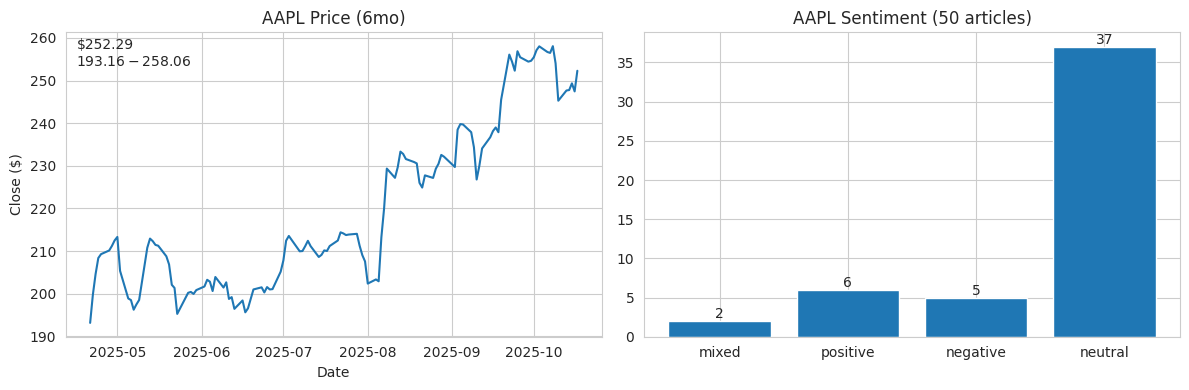

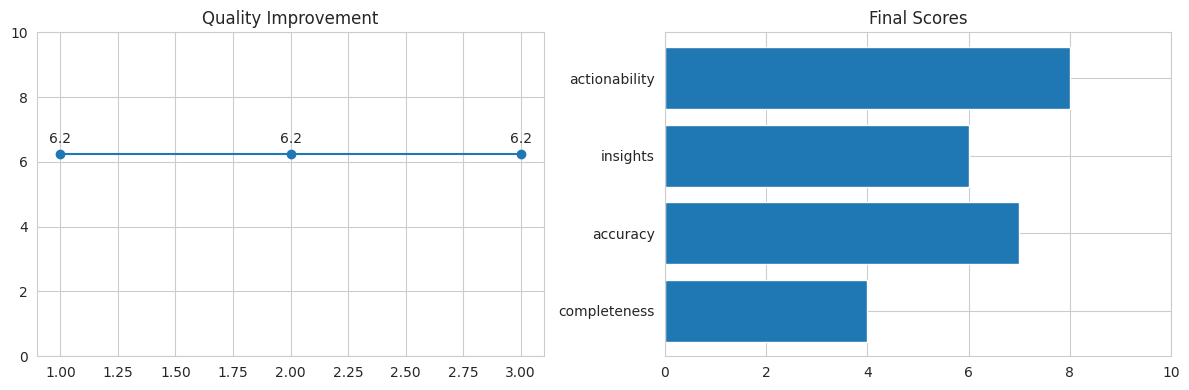

Quality: 6.2 → 6.2 (+0.0)
Loading: investment_analysis_AAPL_20251017_203232.json

AAPL | 2025-10-17

Summary
----------------------------------------------------------------------
Investment Analysis for AAPL Thesis: AAPL is currently trading at $252.29 with a
P/E ratio of 38.34, indicating a premium valuation backed by strong market
confidence in its growth prospects. Given its 52-week range of $169.21 to
$260.10, AAPL has demonstrated significant investor interest, particularly as
technology demand surges, especially in the AI sector.... Recommendation: BUY
(target: $277.52) Quality: 6.2/10

Thesis
----------------------------------------------------------------------
   AAPL is currently trading at $252.29 with a P/E ratio of 38.34, indicating a
premium valuation backed by strong market confidence in its growth
prospects. Given its 52-week range of $169.21 to $260.10, AAPL has
demonstrated significant investor interest, particularly as technology
demand surges, especially in the AI 

{'symbol': 'AAPL',
 'timestamp': '2025-10-17T20:31:25.149570',
 'components': {'plan': ['1. **Define Investment Objectives**',
   '2. **Gather Data**',
   '3. **Perform Fundamental Analysis**',
   '4. **Conduct Technical Analysis**',
   '5. **Evaluate Qualitative Factors**',
   '6. **Synthesize Findings**',
   '7. **Perform Quality Checks**',
   '8. **Prepare Investment Recommendation**',
   '9. **Document and Present Findings**',
   '10. **Monitor and Review**'],
  'data_collection': {'routing': {'Analyze price trends for AAPL': {'agent': 'MarketPro',
     'result': {'symbol': 'AAPL',
      'price_data': {'symbol': 'AAPL',
       'company_name': 'Apple Inc.',
       'sector': 'Technology',
       'current_price': 252.29,
       'market_cap': 3744081903616,
       'pe_ratio': 38.341946,
       'dividend_yield': 0.42,
       '52_week_high': 260.1,
       '52_week_low': 169.21,
       'avg_volume': 54379421,
       'recommendation': 'buy'},
      'technical_analysis': "### Trend Analysis

In [14]:
# Visualize results
visualize_price_and_sentiment(ticker)
visualize_analysis_progress(analysis_results)

# Display formatted report
load_and_display_analysis()